## Crude Oil Continuous Future Prepossessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load crude oil continuous futures data (WTI)
wti = pd.read_csv('crude_oil_fut_cont.csv', index_col='date_')
wti.drop(['calcseriescode'], axis=1, inplace=True)
wti.index_name = 'date'
wti.columns = ['open', 'high', 'low', 'volume', 'close', 'openinterest']
wti = wti.sort_index()
wti


,open,high,low,volume,close,openinterest
date_,,,,,,
1983-03-30,29.250000,29.559998,29.009995,949.0,29.399994,NaN
1983-03-31,29.399994,29.599991,29.250000,521.0,29.269990,NaN
1983-04-04,29.299988,29.699997,29.289994,156.0,29.439988,NaN
1983-04-05,29.500000,29.799988,29.500000,175.0,29.709992,NaN
1983-04-06,29.899994,29.919999,29.649994,392.0,29.899994,NaN
...,...,...,...,...,...,...
2025-10-15,58.570000,59.040000,58.310000,6974.0,58.410000,115397.0
2025-10-16,58.680000,58.860000,57.480000,8065.0,57.640000,80581.0
2025-10-17,57.460000,58.190000,57.170000,9458.0,58.100000,55793.0


In [2]:
# Convert to float and ensure all prices are positive
wti = wti.astype(float)
for col in ['open', 'high', 'low', 'close']:
    wti[col] = wti[col].abs()

wti.head()


,open,high,low,volume,close,openinterest
date_,,,,,,
1983-03-30,29.250000,29.559998,29.009995,949.0,29.399994,NaN
1983-03-31,29.399994,29.599991,29.250000,521.0,29.269990,NaN
1983-04-04,29.299988,29.699997,29.289994,156.0,29.439988,NaN
1983-04-05,29.500000,29.799988,29.500000,175.0,29.709992,NaN
1983-04-06,29.899994,29.919999,29.649994,392.0,29.899994,NaN


In [3]:
# Build adjusted close using cumulative total return
wti['return'] = wti['close'].pct_change()
growth = 1.0 + wti['return'].fillna(0.0)
base_close = wti['close'].iloc[0]

wti_adj = wti.copy()
wti_adj['close'] = base_close * growth.cumprod()

# Scale open/high/low proportionally to maintain their ratios to unadjusted close
scale = wti_adj['close'] / wti['close'].replace(0, np.nan)
scale = scale.replace([np.inf, -np.inf], np.nan).ffill().fillna(1.0)

for col in ['open', 'high', 'low']:
    wti_adj[col] *= scale

wti_adj


,open,high,low,volume,close,openinterest,return
date_,,,,,,,
1983-03-30,29.250000,29.559998,29.009995,949.0,29.399994,NaN,NaN
1983-03-31,29.399994,29.599991,29.250000,521.0,29.269990,NaN,-0.004422
1983-04-04,29.299988,29.699997,29.289994,156.0,29.439988,NaN,0.005808
1983-04-05,29.500000,29.799988,29.500000,175.0,29.709992,NaN,0.009171
1983-04-06,29.899994,29.919999,29.649994,392.0,29.899994,NaN,0.006395
...,...,...,...,...,...,...,...
2025-10-15,58.570000,59.040000,58.310000,6974.0,58.410000,115397.0,-0.004092
2025-10-16,58.680000,58.860000,57.480000,8065.0,57.640000,80581.0,-0.013183
2025-10-17,57.460000,58.190000,57.170000,9458.0,58.100000,55793.0,0.007981


In [4]:
def transform_price_series_fintsbridge(df, price_cols=["open", "high", "low", "close"]):
    """
    Apply FinTSBridge-style transformation:
      z_price = log(P / P0) + 100
      z_volume = log(1 + volume)
    Anchored at the first adjusted close.
    """
    p0_close = df.iloc[0]["close"]
    out = {}
    for col in price_cols:
        out[f"z_{col}"] = np.log(df[col] / p0_close) + 100
    out["z_volume"] = np.log(df["volume"] + 1)
    return pd.DataFrame(out, index=df.index)


In [5]:
wti_transformed = transform_price_series_fintsbridge(wti_adj)
wti_transformed

,z_open,z_high,z_low,z_close,z_volume
date_,,,,,
1983-03-30,99.994885,100.005428,99.986646,100.000000,6.856462
1983-03-31,100.000000,100.006780,99.994885,99.995568,6.257668
1983-04-04,99.996593,100.010152,99.996251,100.001359,5.056246
1983-04-05,100.003396,100.013514,100.003396,100.010489,5.170484
1983-04-06,100.016864,100.017533,100.008467,100.016864,5.973810
...,...,...,...,...,...
2025-10-15,100.689228,100.697221,100.684779,100.686493,8.850088
2025-10-16,100.691104,100.694167,100.670443,100.673222,8.995413
2025-10-17,100.670095,100.682719,100.665035,100.681171,9.154722


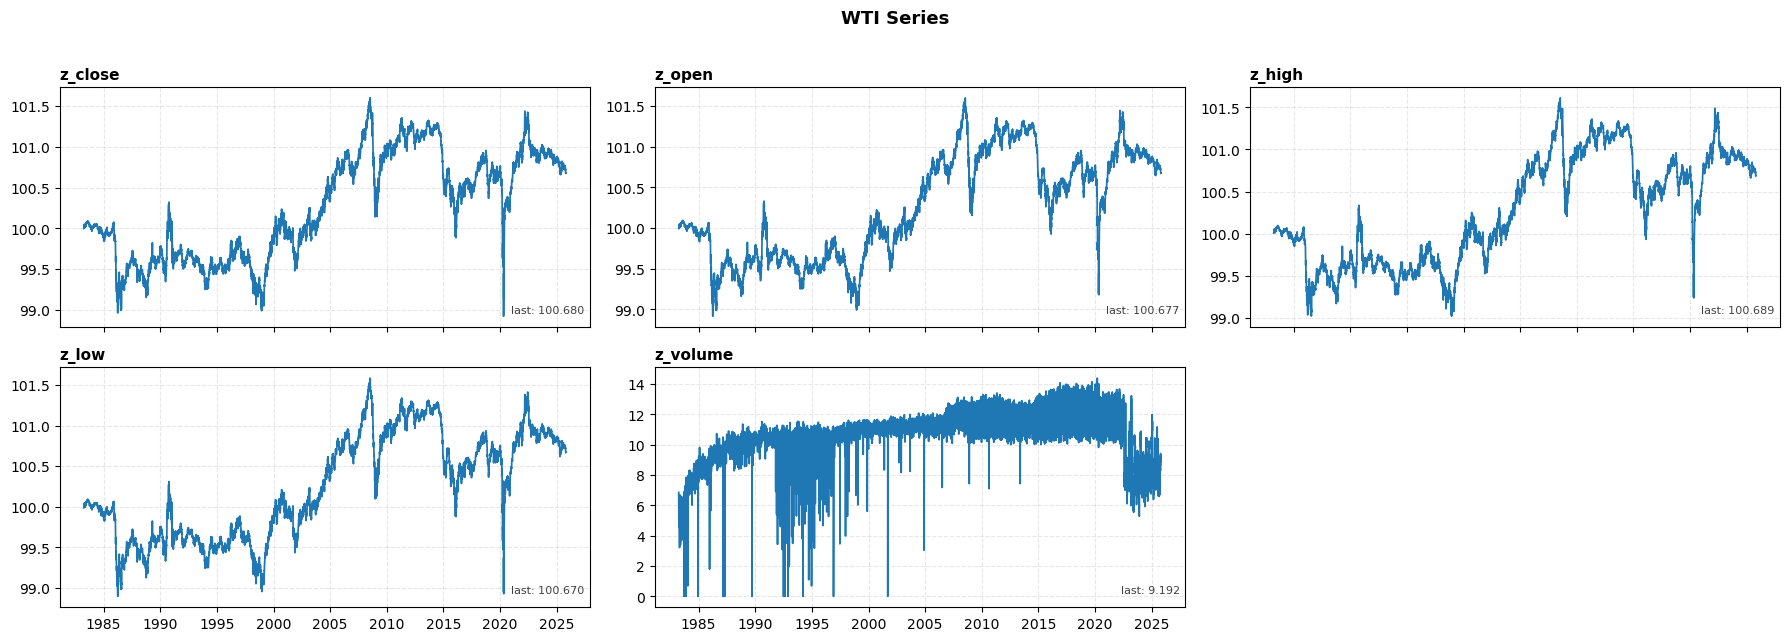

In [6]:
# %%  (Drop-in replacement for Block 5 — Fast plotting)
import numpy as np
import matplotlib.pyplot as plt

def plot_wti(df, candidates=("return", "z_close", "z_open", "z_high", "z_low", "z_volume"),
             title_prefix="WTI Series"):
    """
    Fast multi-panel plot:
    - Uses your plot_crsp layout and axis style.
    - Converts index to DatetimeIndex once.
    - Drops NaNs per-series to avoid masked plotting overhead.
    """
    data = df.copy()

    # Ensure DatetimeIndex once
    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index, errors="coerce")
    data = data.sort_index()

    cols = [c for c in candidates if c in data.columns]
    n = len(cols)
    if n == 0:
        print("No columns to plot.")
        return

    ncols = 3 if n <= 6 else 4
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 3.2 * nrows), sharex=True)
    axes = np.array(axes).ravel() if isinstance(axes, np.ndarray) else np.array([axes])

    for i, c in enumerate(cols):
        ax = axes[i]
        s = data[c].dropna()
        if s.empty:
            ax.set_visible(False)
            continue

        # Plot with numpy arrays for speed
        x = s.index.values
        y = s.values
        ax.plot(x, y, linewidth=1.25)

        ax.set_title(c, loc="left", fontsize=11, fontweight="bold")
        ax.grid(True, linestyle="--", alpha=0.3)
        ax.text(0.99, 0.05, f"last: {y[-1]:.3f}",
                transform=ax.transAxes, ha="right", va="bottom",
                fontsize=8, alpha=0.75)

    # Remove any unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f"{title_prefix}", y=0.995, fontsize=13, fontweight="bold")
    fig.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

# Example:
plot_wti(wti_transformed)


In [8]:
wti_transformed.to_csv('crude_oil_preprocessed.csv')
print("Exported cleaned file: crude_oil_preprocessed.csv")

Exported cleaned file: crude_oil_preprocessed.csv
